<a href="https://colab.research.google.com/github/bathaee/QGAN-EQ-GAN/blob/main/Using_ZNE_to_compute_the_energy_landscape_of_a_variational_circuit_with_Qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit --upgrade
!pip install qiskit-machine-learning
!pip install qiskit-optimization[cplex]
!pip install mitiq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 15.0 MB/s eta 0:00:00


In [ ]:
from mitiq.interface.mitiq_qiskit import qiskit_utils
from qiskit import QuantumCircuit, transpile, BasicAer

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

print(qc)


     ┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1 


In [ ]:
import mitiq


mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.25.0

Core Dependencies
-----------------
Cirq Version:	1.1.0
NumPy Version:	1.22.4
SciPy Version:	1.10.1

Optional Dependencies
---------------------
PyQuil Version:	3.5.0
Qiskit Version:	0.43.0
Braket Version:	Not installed

Python Version:	3.10.11
Platform Info:	Linux (x86_64)


In [ ]:
import cirq
from mitiq.interface import accept_any_qprogram_as_input


@accept_any_qprogram_as_input
def executor(circuit: mitiq.QPROGRAM) -> float:
    return cirq.DensityMatrixSimulator().simulate(
        circuit.with_noise(cirq.depolarize(p=0.01))
    ).final_density_matrix[0, 0].real 

In [ ]:
from mitiq import zne


circuit = cirq.Circuit([cirq.X.on(cirq.LineQubit(0))] * 50)
a = executor(circuit)
print(circuit)
zne_value = zne.execute_with_zne(circuit, executor)
print("ZNE value:", zne_value)
print("without ZNE value:", a)
type(cirq.DensityMatrixSimulator().simulate(
        circuit.with_noise(cirq.depolarize(p=0.01))
    ).final_density_matrix[0, 0].real) 

0: ───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───X───
ZNE value: 0.9415782690048213
without ZNE value: 0.7555592


numpy.float32

In [ ]:
zne_value = zne.execute_with_zne(
    circuit,
    executor,
    scale_noise=zne.scaling.fold_global,
    factory=zne.inference.ExpFactory(scale_factors=[1.0, 3.0, 5.0, 7.0, 9.0])
)
print("ZNE value:", zne_value)

ZNE value: 0.9999961467128782


In [ ]:
qreg = cirq.LineQubit.range(2)
circ = cirq.Circuit(
    cirq.ops.H.on(qreg[0]),
    cirq.ops.CNOT.on(qreg[0] , qreg[1])
)
print("Original circuit:", circ, sep="\n")

Original circuit:
0: ───H───@───
          │
1: ───────X───


In [ ]:
folded = zne.scaling.fold_gates_from_left(
    circ, scale_factor=2
)
print("Folded circuit:", folded, sep="\n")

Folded circuit:
0: ───H───H───H───@───
                  │
1: ───────────────X───


In [ ]:
folded = zne.scaling.fold_gates_from_right(
    circ, scale_factor=2
)
print("Folded circuit:", folded, sep="\n")

Folded circuit:
0: ───H───@───@───@───
          │   │   │
1: ───────X───X───X───


In [ ]:
folded = zne.scaling.fold_global(circ, scale_factor=3.)
print("Folded circuit:", folded, sep="\n")

Folded circuit:
0: ───H───@───@───H───H───@───
          │   │           │
1: ───────X───X───────────X───


In [ ]:
from mitiq import pec

representation = pec.represent_operation_with_local_depolarizing_noise(
    ideal_operation=cirq.Circuit(circuit[0]), noise_level=0.01
)
print("Representation of ideal operation:", representation, sep="\n\n")

pec_value = pec.execute_with_pec(
    circuit,
    executor,
    representations=[representation],
    num_samples=100,  # Remove argument or increase for better accuracy.
)
print("\n\nPEC value:", pec_value)

Representation of ideal operation:

0: ───X─── = 1.010*(0: ───X───)-0.003*(0: ───X───X───)-0.003*(0: ───X───Y───)-0.003*(0: ───X───Z───)


PEC value: 1.1560433713129572


In [ ]:
#Using ZNE to compute the energy landscape of a variational circuit with Qiskit

import matplotlib.pyplot as plt
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit_aer.noise import NoiseModel, depolarizing_error

from mitiq.zne import mitigate_executor
from mitiq.zne.inference import RichardsonFactory

In [ ]:
def variational_circuit(gamma: float) -> QuantumCircuit:
    """Returns a two-qubit circuit for a given variational parameter.

    Args:
        gamma: The variational parameter.

    Returns:
        The two-qubit circuit with a fixed gamma.
    """
    circuit = QuantumCircuit(2)
    circuit.rx(gamma, 0)
    circuit.cnot(0, 1)
    circuit.rx(gamma, 1)
    circuit.cnot(0, 1)
    circuit.rx(gamma, 0)
    
    return circuit

In [ ]:
circuit = variational_circuit(gamma=np.pi)
circuit.draw()

┌───────┐                   ┌───────┐
q_0: ┤ Rx(π) ├──■─────────────■──┤ Rx(π) ├
     └───────┘┌─┴─┐┌───────┐┌─┴─┐└───────┘
q_1: ─────────┤ X ├┤ Rx(π) ├┤ X ├─────────
              └───┘└───────┘└───┘

In [ ]:
# observable to measure
z = np.diag([1, -1])
hamiltonian = np.kron(z, z)

def noiseless_executor(circuit: QuantumCircuit) -> float:
    """Simulates the execution of a circuit without noise.

    Args:
        circuit: The input circuit.

    Returns:
        The expectation value of the ZZ observable.
    """
    # avoid mutating the input circuit
    circ = circuit.copy()
    circ.save_density_matrix()

    # execute experiment without noise
    job = qiskit.execute(
        experiments=circ,
        backend=qiskit.Aer.get_backend("aer_simulator_density_matrix"),
        noise_model=None,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        shots=1,
    )
    rho = job.result().data()["density_matrix"]

    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation 

In [ ]:
# strength of noise channel
noise_level = 0.04

def executor_with_noise(circuit: QuantumCircuit) -> float:
    """Simulates the execution of a circuit with depolarizing noise.

    Args:
        circuit: The input circuit.

    Returns:
        The expectation value of the ZZ hamiltonian.
    """
    # avoid mutating the input circuit
    circ = circuit.copy()
    circ.save_density_matrix()
    
    # Initialize qiskit noise model. In this case a depolarizing
    # noise model with the same noise strength on all gates
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 1), ["rx"]
    )
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 2), ["cx"]
    ) 
    

    # execute experiment with depolarizing noise
    job = qiskit.execute(
        experiments=circ,
        backend=qiskit.Aer.get_backend("aer_simulator_density_matrix"),
        noise_model=noise_model,
        basis_gates=noise_model.basis_gates + ["save_density_matrix"],
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        shots=1,
    )
    rho = job.result().data()["density_matrix"]

    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation     

In [ ]:
type(executor_with_noise(variational_circuit(1)))

numpy.float64

In [ ]:
gammas = np.linspace(0, 2 * np.pi, 50)
noiseless_expectations = [noiseless_executor(variational_circuit(g)) for g in gammas]

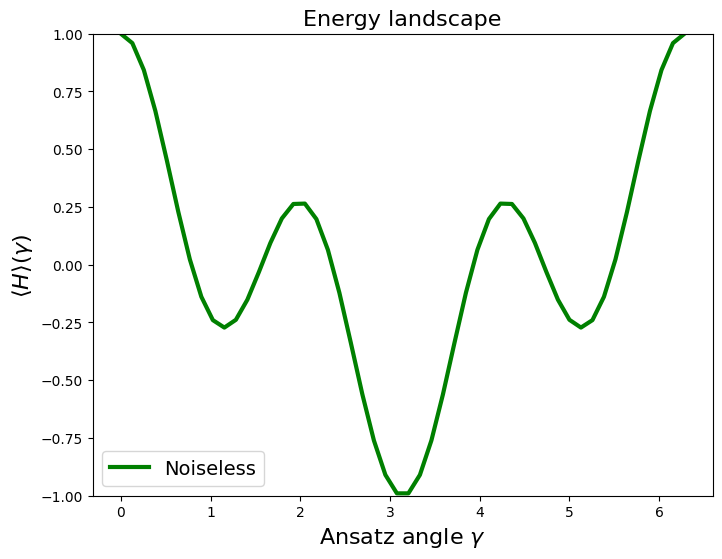

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.title("Energy landscape", fontsize=16)
plt.xlabel(r"Ansatz angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1, 1);
plt.show()

In [ ]:
gammas = np.linspace(0, 2 * np.pi, 50)
expectations = [executor_with_noise(variational_circuit(g)) for g in gammas]

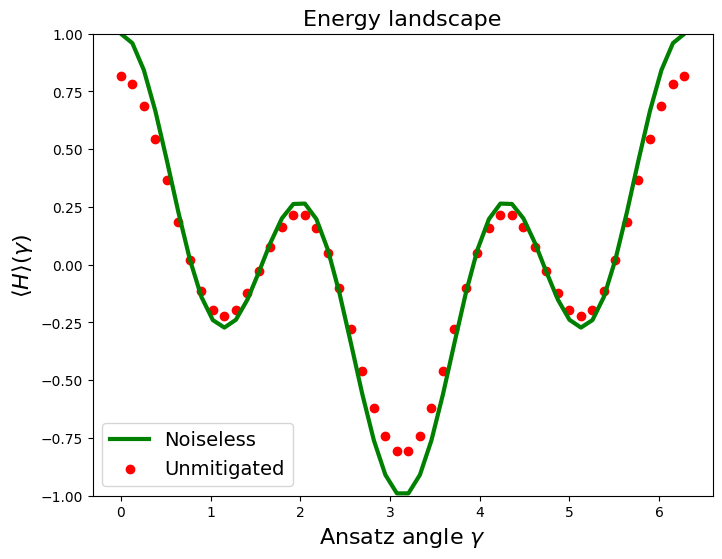

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.scatter(gammas, expectations, color="r", label="Unmitigated")
plt.title(rf"Energy landscape", fontsize=16)
plt.xlabel(r"Ansatz angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1, 1);
plt.show()

In [ ]:
fac = RichardsonFactory(scale_factors=[1, 3, 5])
mitigated_executor = mitigate_executor(executor_with_noise, factory=fac)

In [ ]:
mitigated_expectations = [mitigated_executor(variational_circuit(g)) for g in gammas]

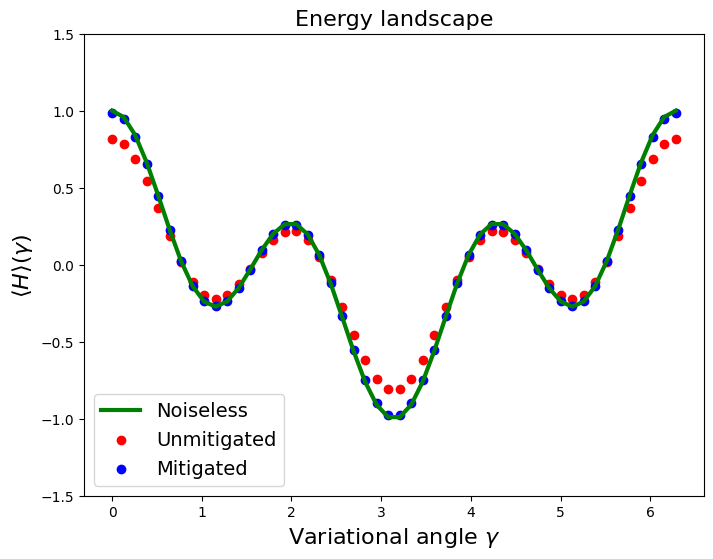

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.scatter(gammas, expectations, color="r", label="Unmitigated")
plt.scatter(gammas, mitigated_expectations, color="b", label="Mitigated")
plt.title(rf"Energy landscape", fontsize=16)
plt.xlabel(r"Variational angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1.5, 1.5);
plt.show()

In [ ]:
print(f"Minimum of the noisy landscape: {round(min(expectations), 3)}")
print(f"Minimum of the mitigated landscape: {round(min(mitigated_expectations), 3)}")
print(f"Theoretical ground state energy: {min(np.linalg.eigvals(hamiltonian))}")

Minimum of the noisy landscape: -0.807
Minimum of the mitigated landscape: -0.976
Theoretical ground state energy: -1.0


In [ ]:
from mitiq.benchmarks import generate_rb_circuits
from mitiq.zne import execute_with_zne
from mitiq import (
    Calibrator,
    Settings,
    execute_with_mitigation,
    MeasurementResult,
)

from qiskit.providers.fake_provider import FakeJakarta  # Fake (simulated) QPU

In [ ]:
n_qubits = 2
depth_circuit = 20
shots = 10 ** 3

In [ ]:
circuit = generate_rb_circuits(n_qubits, depth_circuit,return_type="qiskit")[0]
circuit.measure_all()
print(len(circuit))
#print(circuit)

220


In [ ]:
def execute_circuit(circuit):
    """Execute the input circuit and return the expectation value of |00..0><00..0|"""
    noisy_backend = FakeJakarta()
    noisy_result = noisy_backend.run(circuit, shots=shots).result()
    noisy_counts = noisy_result.get_counts(circuit)
    noisy_expectation_value = noisy_counts[n_qubits * "0"] / shots
    return noisy_expectation_value

In [ ]:
def execute_circuit_new(circuit):
    """Execute the input circuit and return the expectation value of |00..0><00..0|"""
    noisy_backend = FakeJakarta()
    noisy_result = noisy_backend.run(circuit, shots=shots).result()
    rho = noisy_result.data()
    noisy_expectation_value = np.real(np.trace(rho @ hamiltonian))
    return noisy_expectation_value

In [ ]:
def variational_circuit(gamma: float) -> QuantumCircuit:
    """Returns a two-qubit circuit for a given variational parameter.

    Args:
        gamma: The variational parameter.

    Returns:
        The two-qubit circuit with a fixed gamma.
    """
    circuit = QuantumCircuit(2)
    circuit.rx(gamma, 0)
    circuit.cnot(0, 1)
    circuit.rx(gamma, 1)
    circuit.cnot(0, 1)
    circuit.rx(gamma, 0)
    circuit.measure_all()
    return circuit
noisy_backend = FakeJakarta()
noisy_result = noisy_backend.run(variational_circuit(1), shots=shots).result()
noisy_counts = noisy_result.get_counts()
#noisy_expectation_value = noisy_counts[n_qubits * "0"] / shots
#noisy_expectation_value = np.real(np.trace(rho @ hamiltonian))

In [ ]:
print(noisy_counts)

{'11': 3, '00': 4, '01': 3}


In [ ]:
type(execute_circuit_new(variational_circuit(1)))

ValueError: ignored

In [ ]:
mitigated = execute_with_zne(circuit, execute_circuit)
unmitigated = execute_circuit(circuit)
ideal = 1 #property of RB circuits

print("ideal = \t \t",ideal)
print("unmitigated = \t \t",unmitigated)
print("mitigated = \t \t",mitigated)

ideal = 	 	 1
unmitigated = 	 	 0.941
mitigated = 	 	 0.9459999999999998
